# Data Preparation and modules importing

In [194]:
import pandas as pd  # linear algebra
import numpy as np  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # visuals
import seaborn as sns  # visuals
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

#.drop(['family', 'id', 'store_nbr', 'onpromotion'], axis=1)
train = pd.read_csv('train.csv', parse_dates=['date'], infer_datetime_format=True)

test = pd.read_csv('test.csv')



# importing additional data
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
#transactions = pd.read_csv('transactions.csv')
holidays = pd.read_csv('holidays_events.csv')

train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [195]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [196]:
sales = train.copy()
sales = sales.set_index('date').to_period('D')

sales = sales.drop(['family', 'id', 'store_nbr', 'onpromotion'], axis=1)
sales.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


In [197]:
avg_sales = sales.groupby('date').mean()

avg_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


# Time Dummy Series

### Time Series 

In [198]:
avg_sales['time'] = np.arange(len(avg_sales.index))
avg_sales.head()

,sales,time
date,,
2013-01-01,1.409438,0
2013-01-02,278.390807,1
2013-01-03,202.840197,2
2013-01-04,198.911154,3
2013-01-05,267.873244,4


In [199]:
from sklearn.linear_model import LinearRegression


# Training data
X = avg_sales.loc[:, ['time']]   # features
y = avg_sales.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


Text(0.5, 1.0, 'Time Plot of Sales')

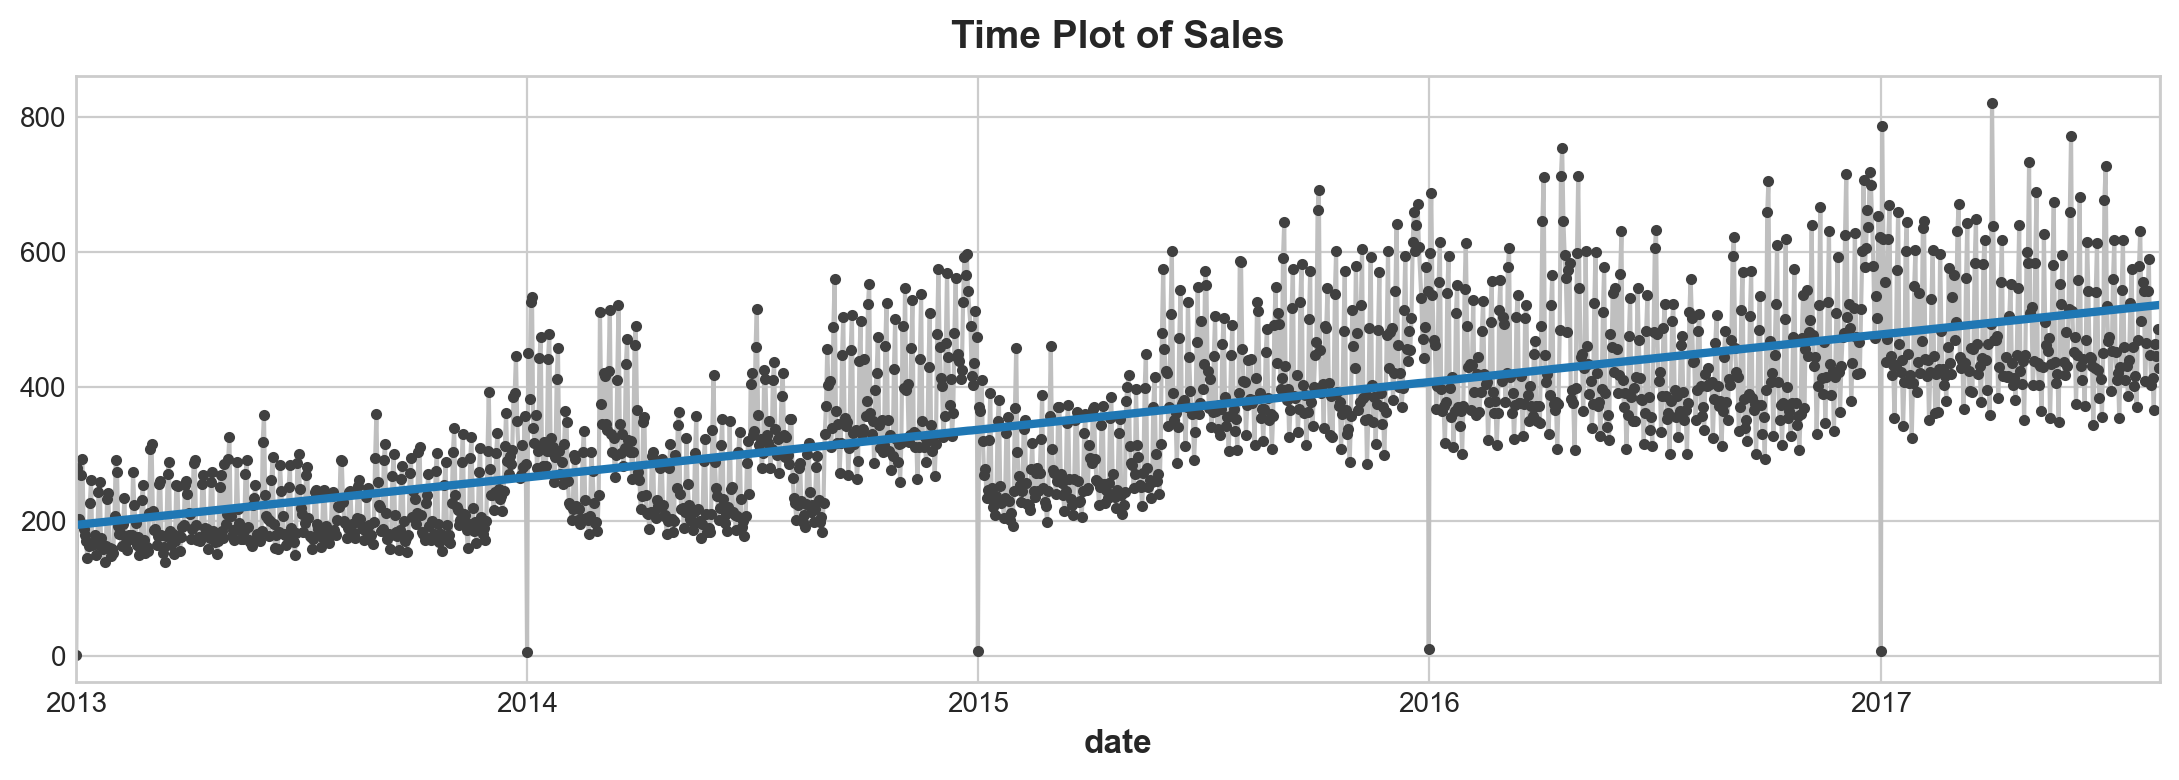

In [200]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Sales')


In [201]:
#lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation.
avg_sales['lag_1'] = avg_sales['sales'].shift(1)
avg_sales = avg_sales.reindex(columns=['sales', 'lag_1'])
avg_sales.head()



,sales,lag_1
date,,
2013-01-01,1.409438,NaN
2013-01-02,278.390807,1.409438
2013-01-03,202.840197,278.390807
2013-01-04,198.911154,202.840197
2013-01-05,267.873244,198.911154


### Lag Series
Here we modeled serial dependence. From the lag plot that sales on one day Sales are correlated with sales from the previous day 'lag_1'.

Text(0.5, 1.0, 'Lag Plot of Sales')

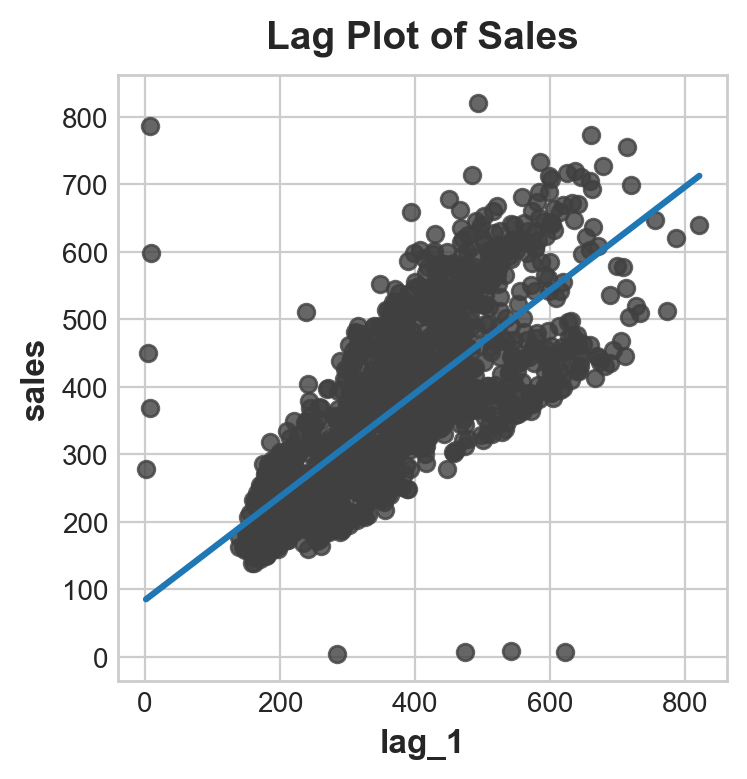

In [202]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='sales', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Sales')


# Moving Average and Sales Trend using DeterministicProcess 
Since this series has daily observations, we are going to choose a  window of 365 days to smooth over any short-term changes within the year.

In [203]:
# Dropping unnessesary columns
avg_sales = avg_sales.drop('lag_1', axis= 1)
avg_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


<AxesSubplot: title={'center': '365-Day Moving Average of Sales '}, xlabel='date'>

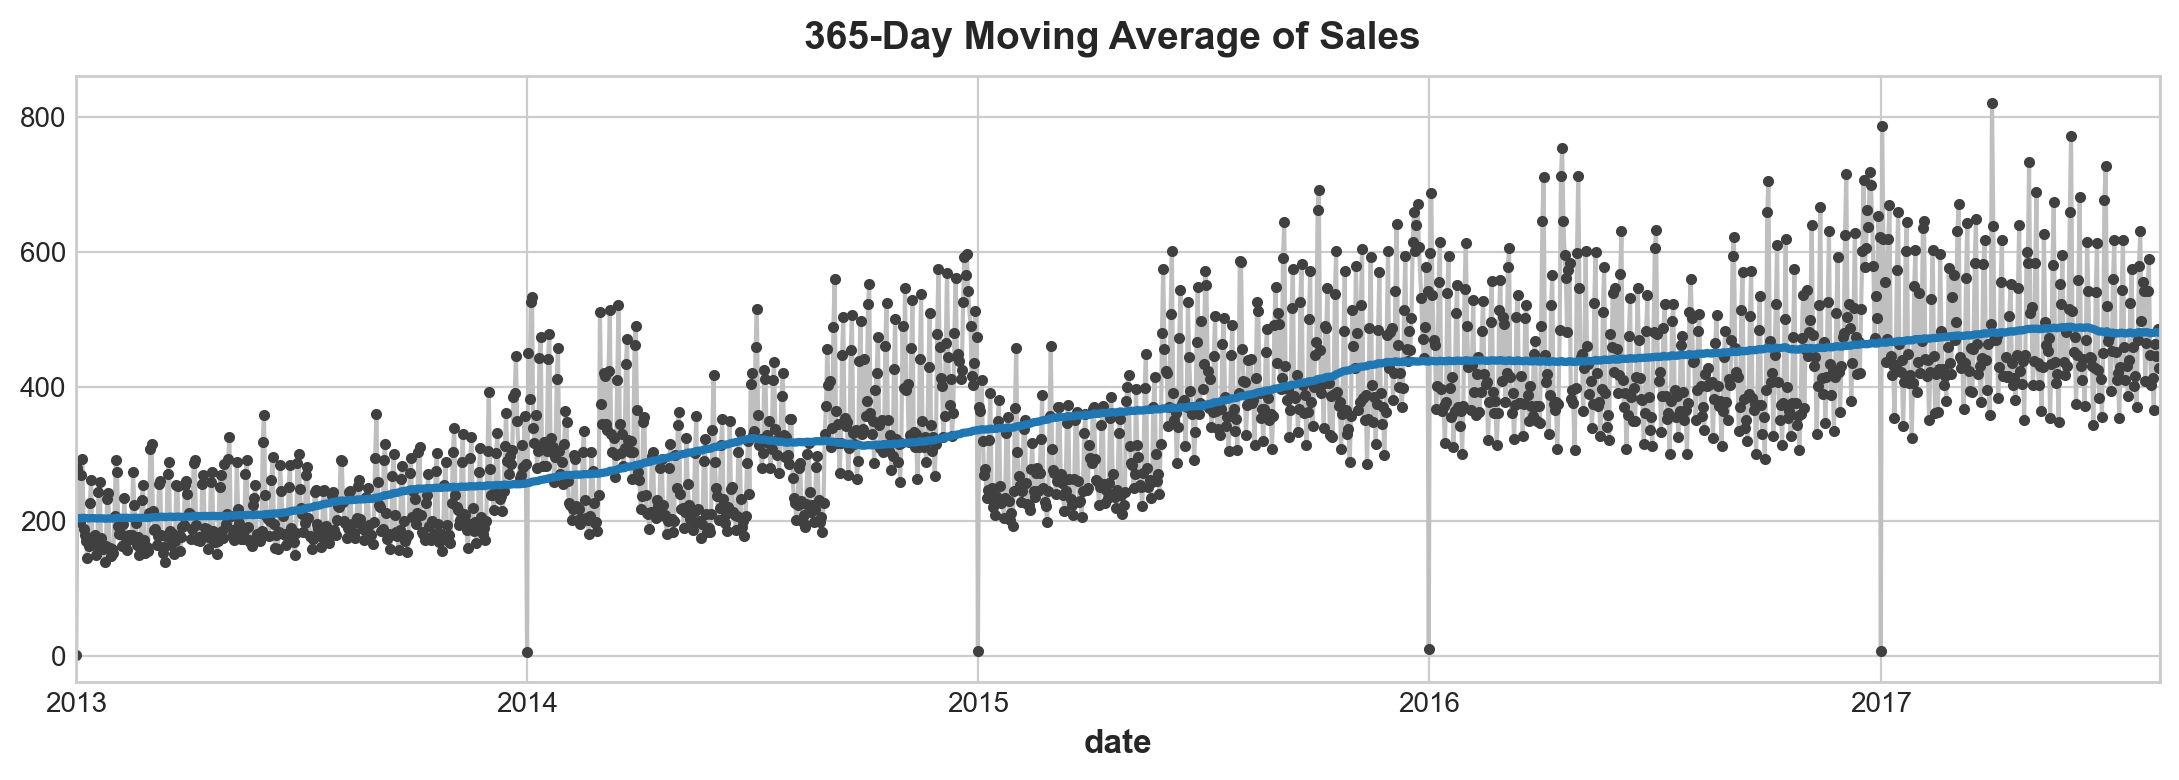

In [204]:
#moving average
moving_average = avg_sales['sales'].rolling(  # using the rolling method to begin a windowed computation
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(**plot_params)
moving_average.plot(
    ax=ax, linewidth=3, title="365-Day Moving Average of Sales ", legend=False)


In [205]:
#avg_sales = avg_sales.reindex(columns=['sales'])


### DeterministicProcess
DeterministicProcess will help us avoid some tricky failure cases that can arise with time series and linear regression.
The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [206]:

from statsmodels.tsa.deterministic import  DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,  # dummy feature for the bias (y_intercept)
    order=1,  # the time dummy (trend)
    drop=True  # dropping terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()


,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


The trend discovered by our LinearRegression model below is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

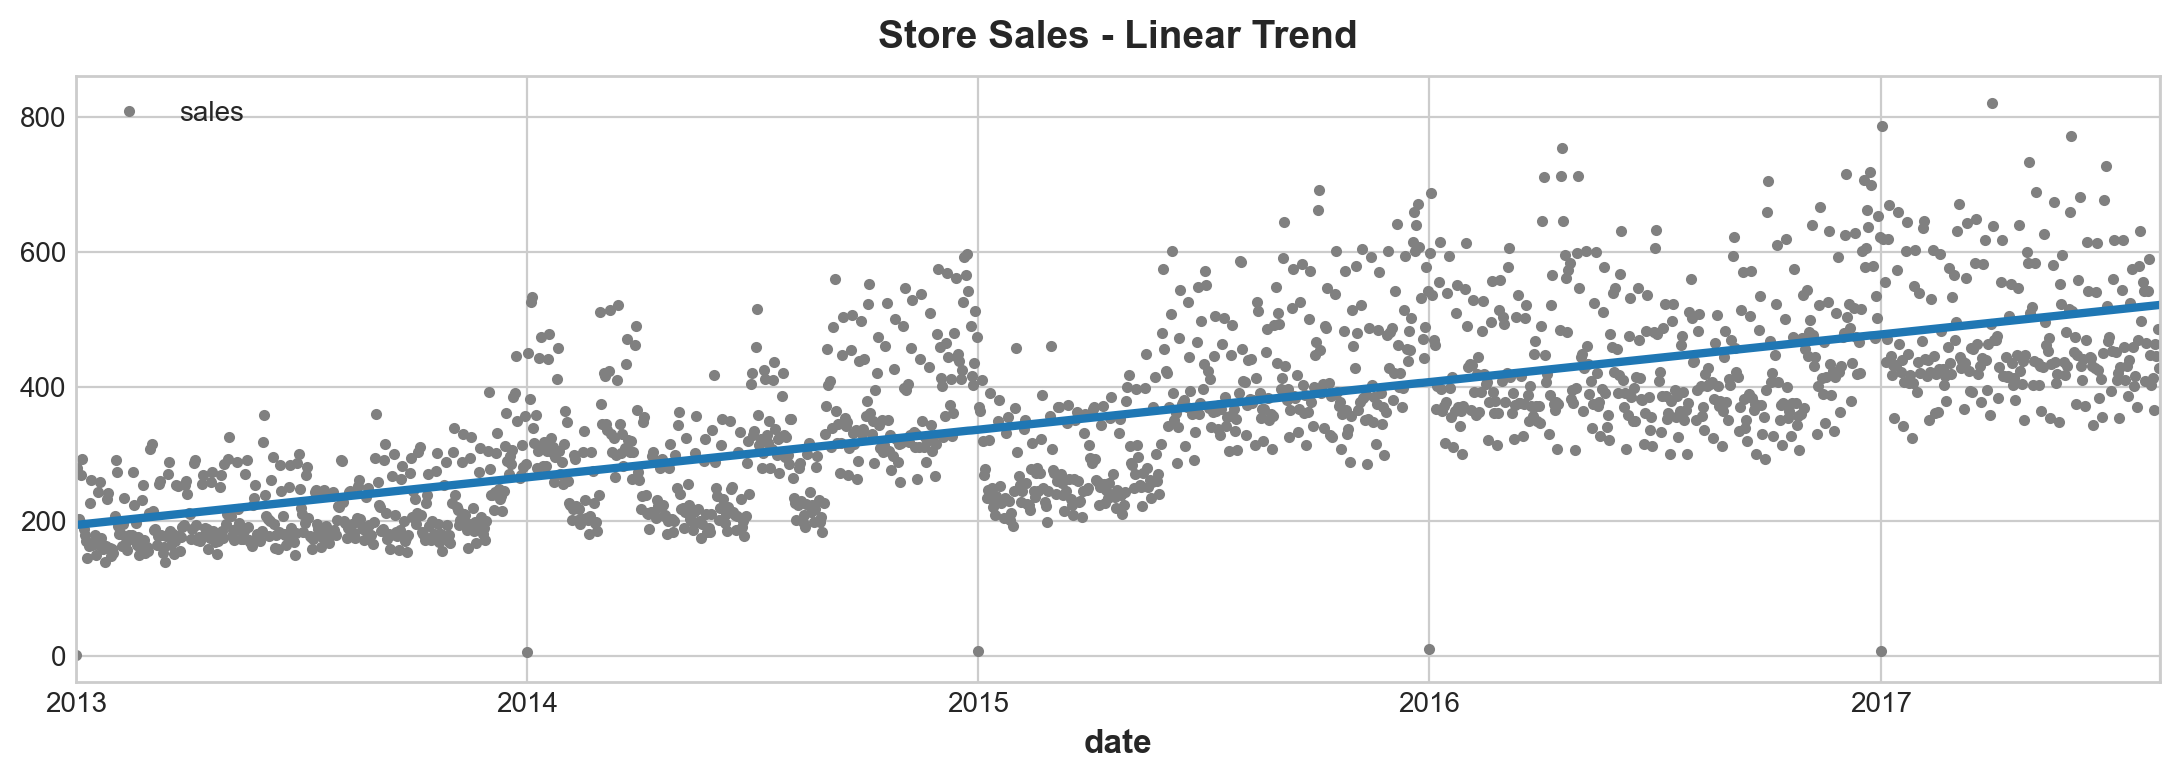

In [207]:
y = avg_sales['sales']  # target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.

lg = LinearRegression(fit_intercept=False)
lg.fit(X, y)

y_pred = pd.Series(lg.predict(X), index=X.index)

ax = avg_sales.plot(style=".", color="0.5", title="Store Sales - Linear Trend")

_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")


Out-of-sample features help us set outside of the obseervation period of the training data.
Hence we can make a 30-days forecast.

In [208]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(lg.predict(X), index=X.index)

y_fore.head()


2017-08-16    521.513055
2017-08-17    521.707402
2017-08-18    521.901749
2017-08-19    522.096096
2017-08-20    522.290443
Freq: D, dtype: float64

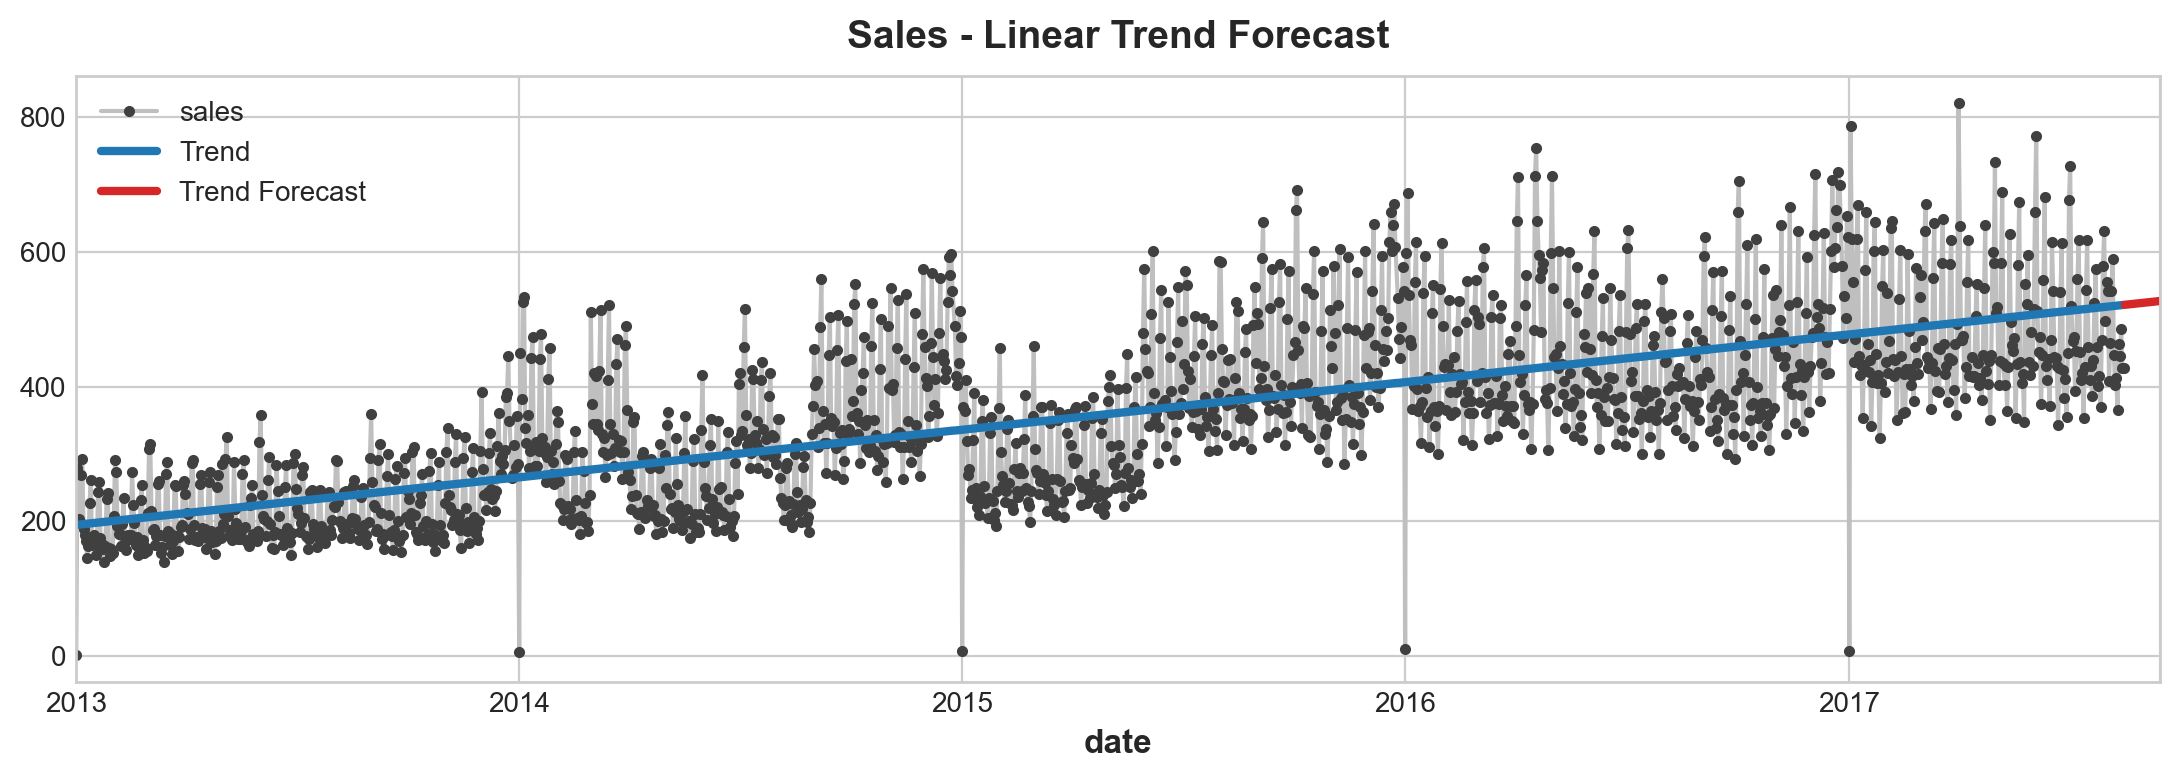

In [209]:
ax = avg_sales["2013-01":].plot(
    title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()


# Seasonality
### Here we will use a seasonal plot to discover seasonal patterns
Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding. By one-hot encoding days of the week, we get weekly seasonal indicators.

**Fourier** features are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

In [210]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

### Weekly and over a year seasonal plots

<AxesSubplot: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

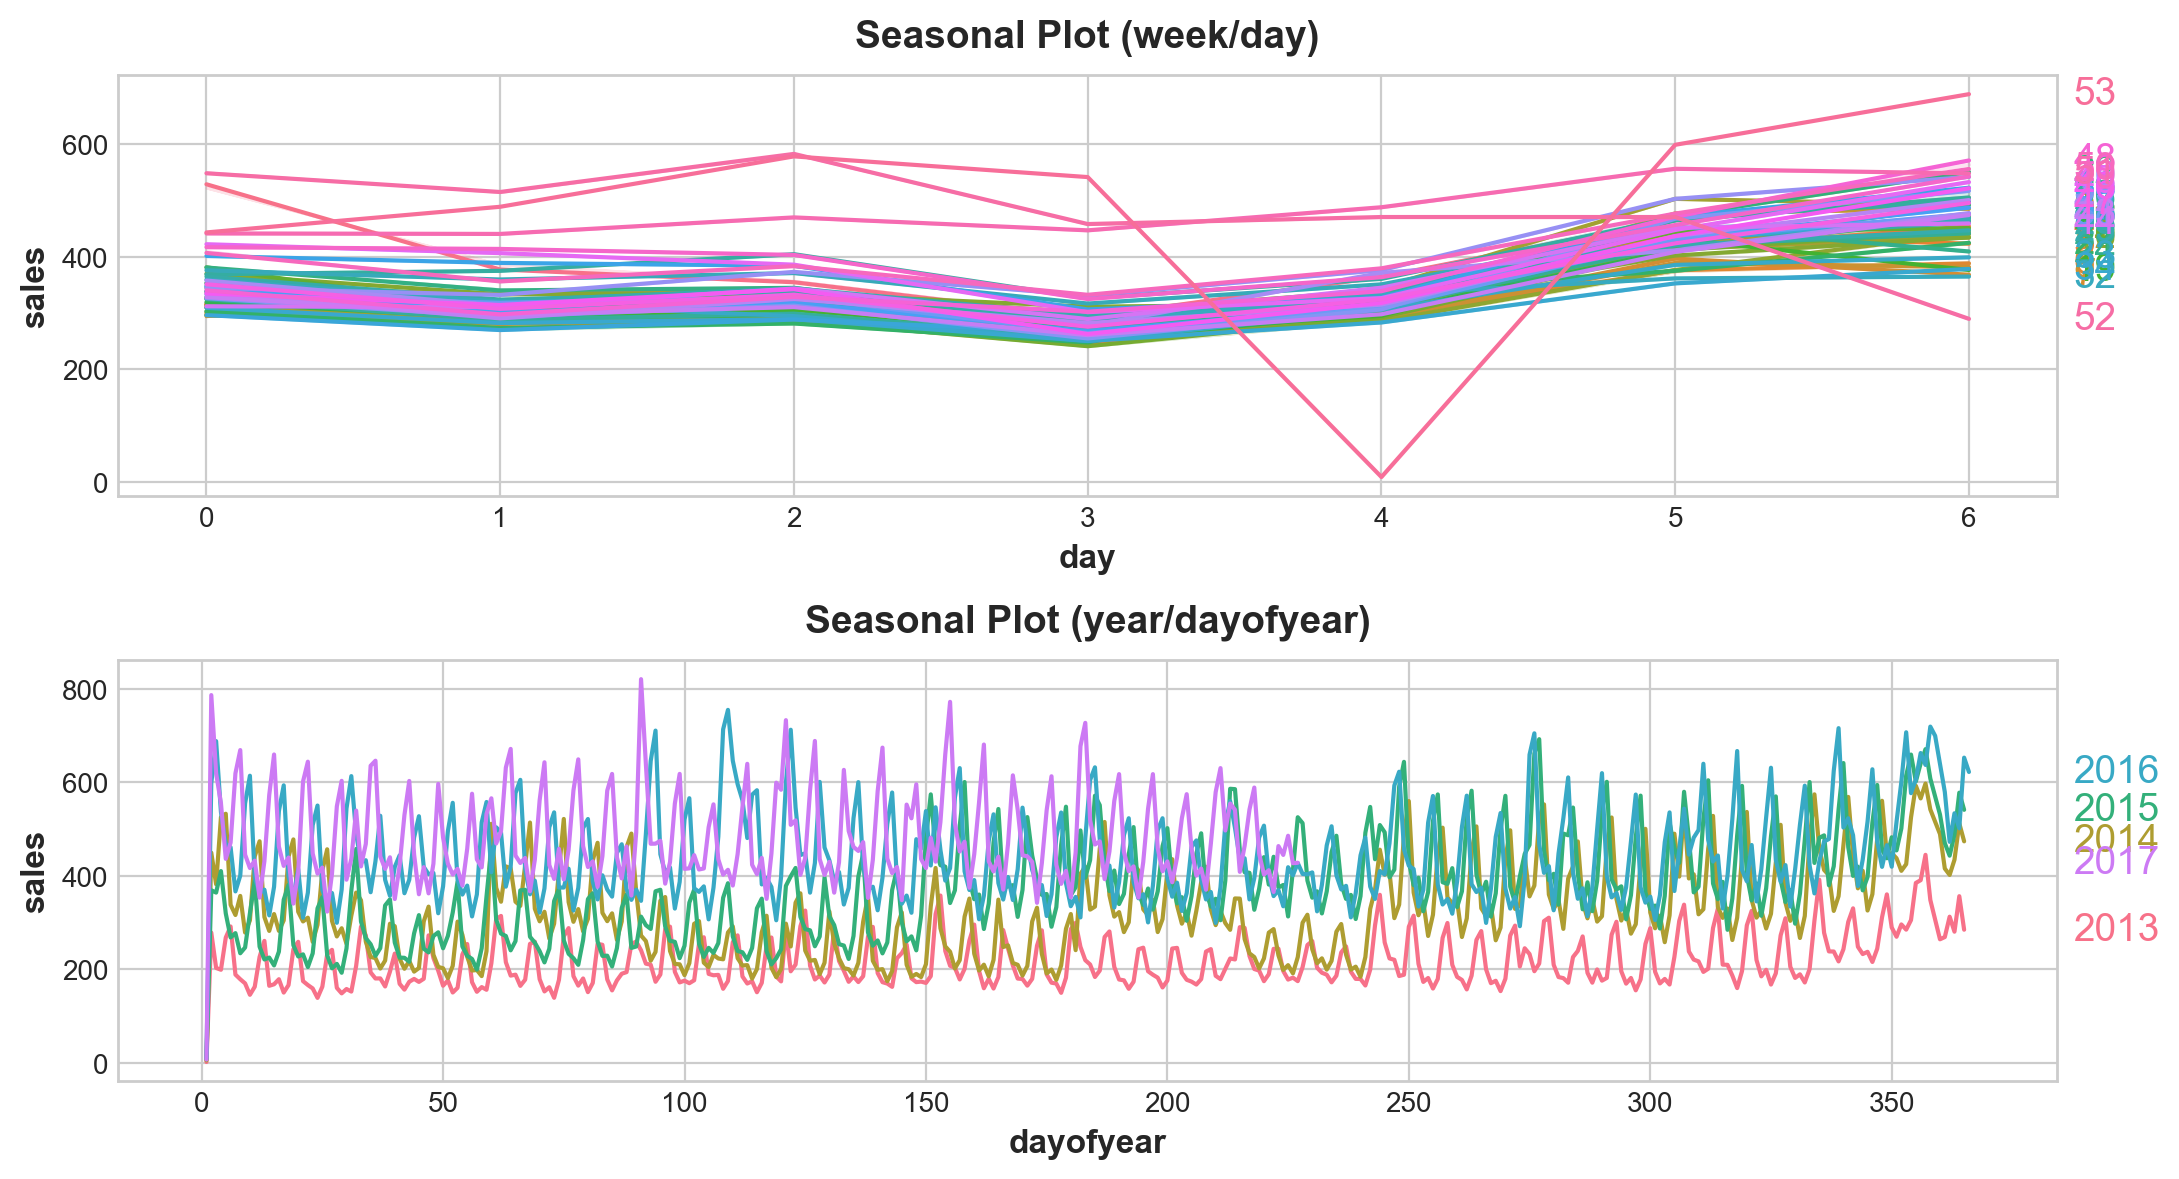

In [211]:


X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek  # the x-axis (freq)
X['week'] = X.index.week  # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y='sales', period='week', freq='day', ax=ax0)
seasonal_plot(X, y='sales', period='year', freq='dayofyear', ax=ax1)


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

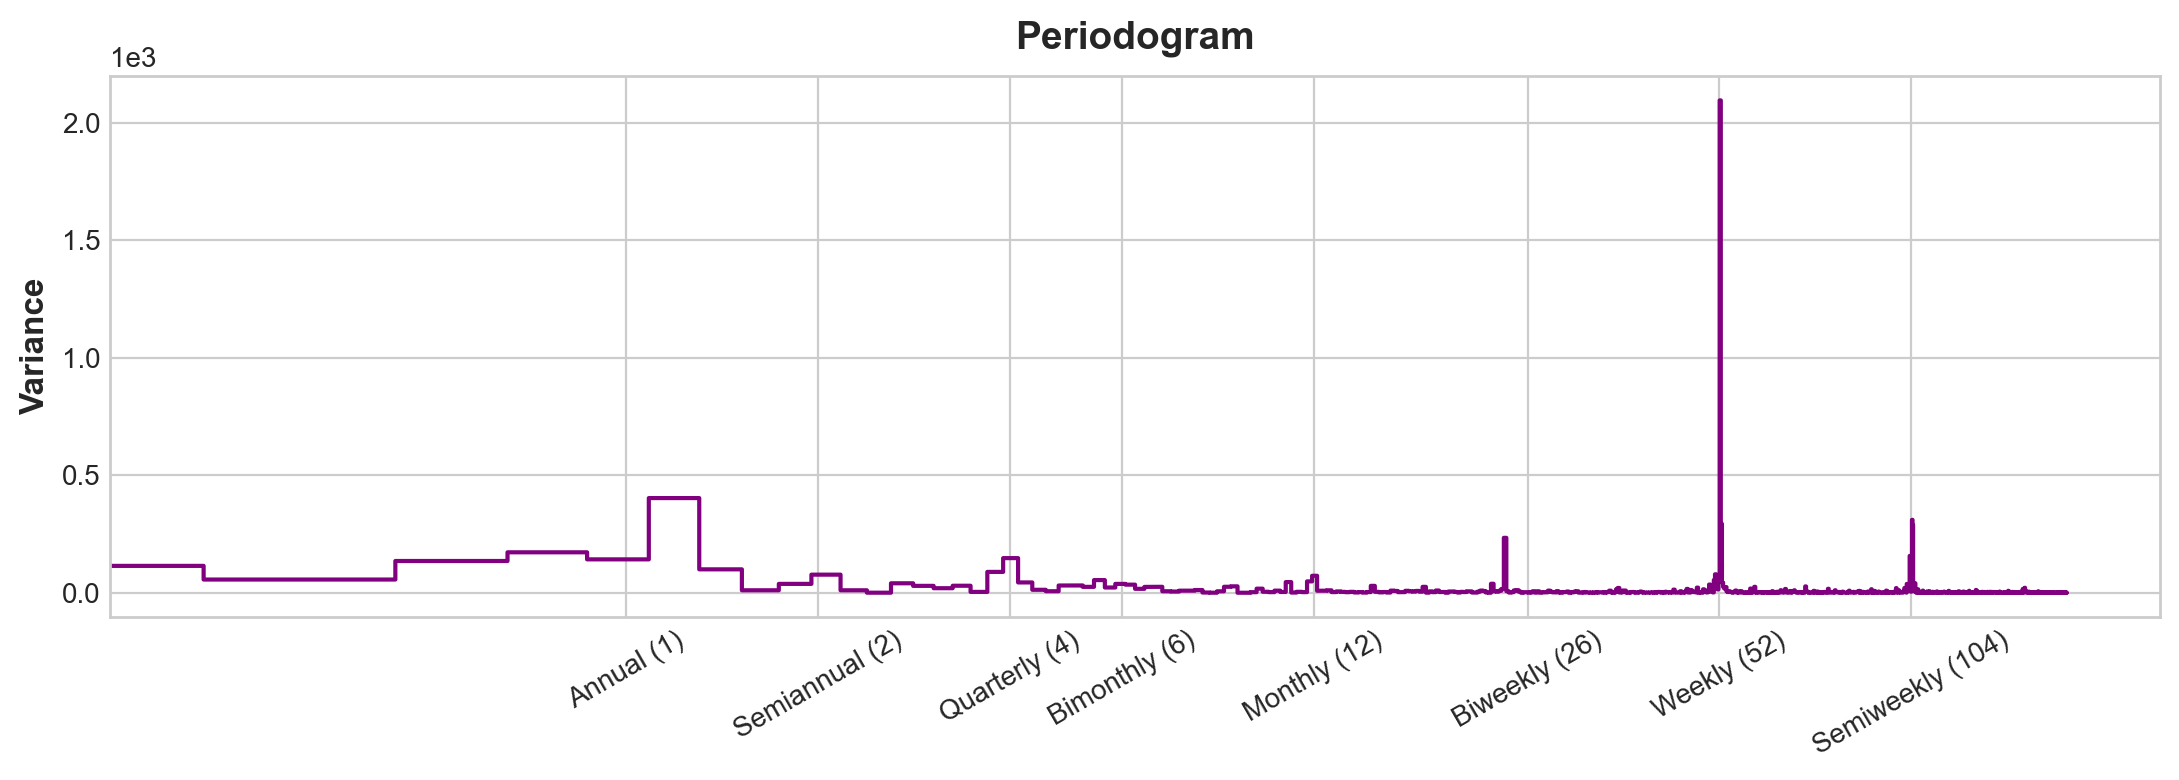

In [212]:
# The periodogram tells you the strength of the frequencies in a time series.
# Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, 
# where a and b are the coefficients of the sine and cosine at that frequency
# as in the Fourier Components plot above).

plot_periodogram(avg_sales.sales)


The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.


We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [213]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# 10 sin/cos pairs for "A"nnual seasonality
fourier = CalendarFourier(freq="A", order=10)

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in avg_sales.index


With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.


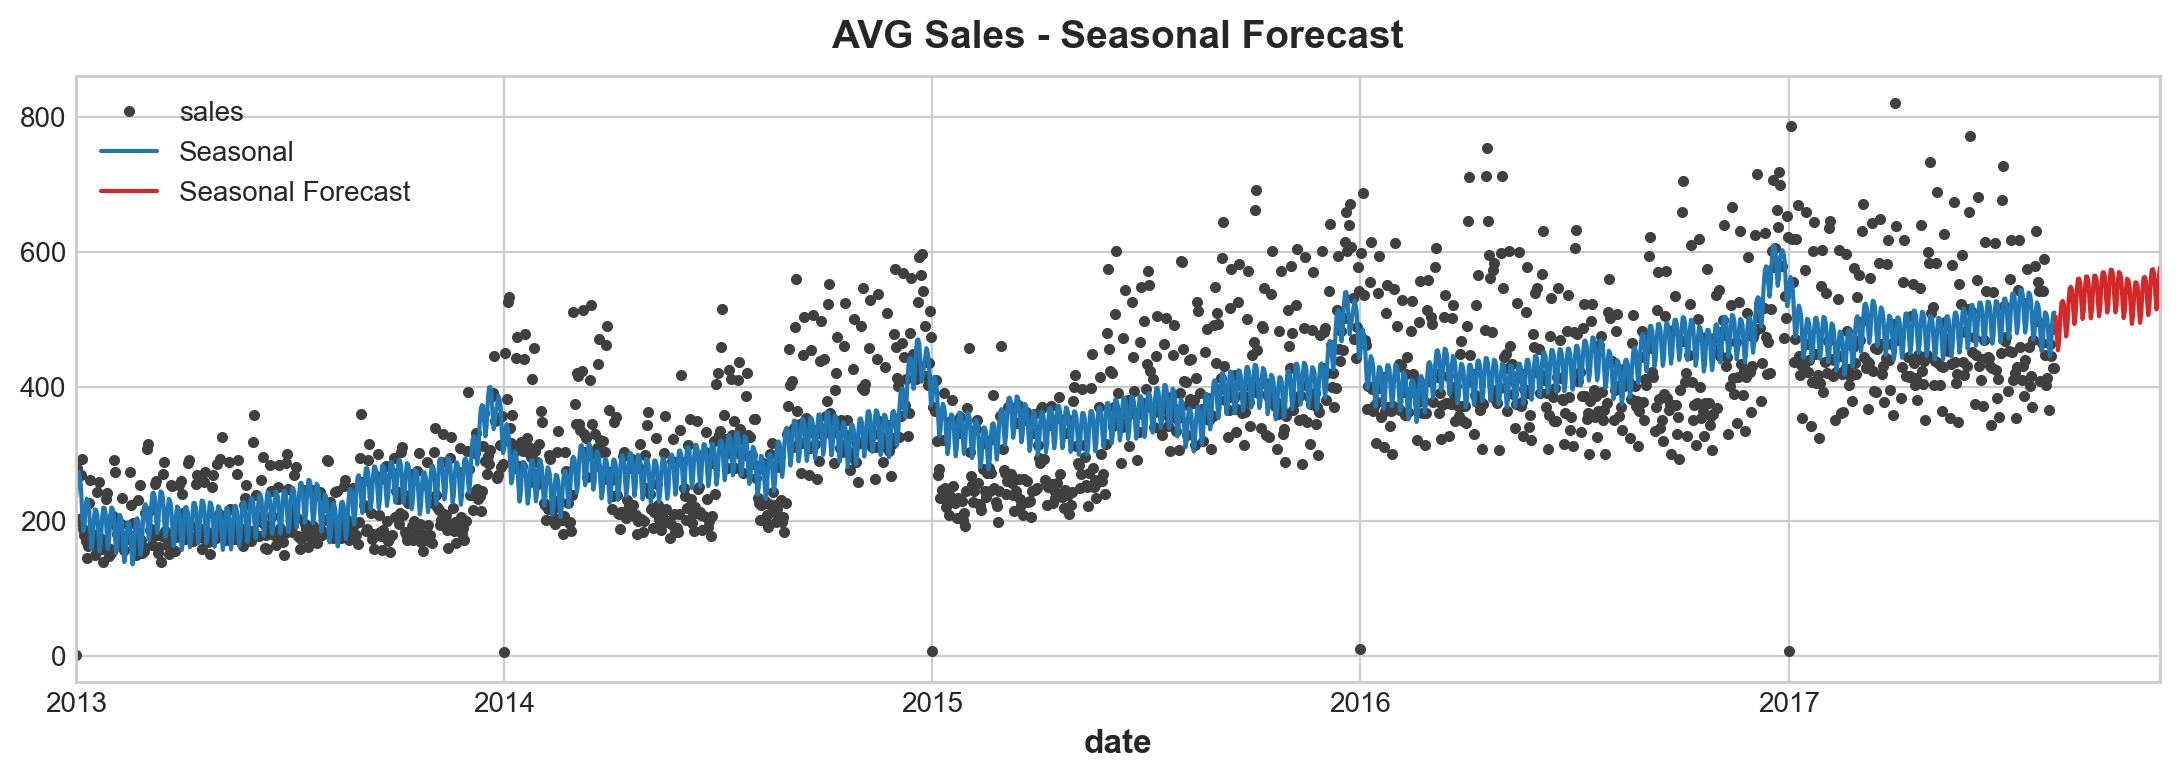

In [214]:


y = avg_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#["2016-01":]
ax = y.plot(color='0.25', style='.',
            title="AVG Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()


# Time Seriaes as Features

### Serial Dependency

One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past.

**The most commonly used measure of serial dependence is known as autocorrelation, which is simply the correlation a time series has with one of its lags.**
If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.
Plotting the partial autocorrelation can help you choose which lag features to use.

The **correlogram** is for lag features essentially what the periodogram is for Fourier features.

Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like mutual information) when choosing lag features. The Sunspots series has lags with non-linear dependence which we might overlook with autocorrelation.

In [215]:
# We will take two approaches. In the first we'll forecast doctor's visits using lag features.
# Our second approach will be to forecast sales using lags of another set of time series

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                        y=y_,
                        scatter_kws=scatter_kws,
                        line_kws=line_kws,
                        lowess=True,
                        ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [217]:
from itertools import groupby


sales_df = train.copy()
sales_df = sales_df.set_index('date').to_period('W')
sales_df = sales_df.groupby('date')


#ax = sales_df.sales.plot(title='Sales Trends', **plot_params)
#_ = ax.set(ylabel="Sales")
sales_df.head()



,id,store_nbr,family,sales,onpromotion
date,,,,,
2012-12-31/2013-01-06,0,1,AUTOMOTIVE,0.0,0
2012-12-31/2013-01-06,1,1,BABY CARE,0.0,0
2012-12-31/2013-01-06,2,1,BEAUTY,0.0,0
2012-12-31/2013-01-06,3,1,BEVERAGES,0.0,0
2012-12-31/2013-01-06,4,1,BOOKS,0.0,0
...,...,...,...,...,...
2017-08-14/2017-08-20,2997324,1,AUTOMOTIVE,1.0,0
2017-08-14/2017-08-20,2997325,1,BABY CARE,0.0,0
2017-08-14/2017-08-20,2997326,1,BEAUTY,6.0,1
